# Customer Subscription Prediction For A Bank Campaign

Problem Statement:

The data is related to direct marketing campaigns of a Portuguese banking institution. Predict if the client will subscribe to a term deposit based on a marketing campaign.

The data is related to direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact 
to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
#sns.set(font_scale = 1)
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams['font.size'] = 5
#plt.rc('xtick', labelsize=10) 
#plt.rc('ytick', labelsize=10)
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder

# import libraries to support modelling, hyperparameter tuning
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV

# import libraries to manage imbalanced data set
from imblearn.under_sampling import ClusterCentroids,RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler,SMOTE

#import sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

#import xgboost classifier
from xgboost import XGBClassifier

#import metrics required for model evaluation
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,roc_auc_score
from sklearn import metrics

In [3]:
'''
#below code was taken from stack exchange, this centers the plots in notebooks

from IPython.display import display, HTML

display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))
'''
#the above code places all the plots in the center but it distorts dataframe head output

'\n#below code was taken from stack exchange, this centers the plots in notebooks\n\nfrom IPython.display import display, HTML\n\ndisplay(HTML("""\n<style>\n.output {\n    display: flex;\n    align-items: center;\n    text-align: center;\n}\n</style>\n"""))\n'

In [4]:
#read the data set, used separator as ';' instead of default ','
df = pd.read_csv('./bank-additional-full.csv',sep=';')

In [5]:
# top 10 rows of data
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
#this dataset doesnt contain null values rather nulls are replaced by 'unknown' labels in catagorical features
print(df.isnull().any().any())
#basic overview of the data frame
df.info()

False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memo

In [7]:
#reading discriptive stats of numerical features 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


In [8]:
#reading discriptive stats for categorical column
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [9]:
#make copy of dataframe, we will process copied dataframe
cdf = df.copy()

In [10]:
#iterate through every catagorical column and replace 'unknown' label with mode of that column 
cat_var = df.select_dtypes(include='object').columns.values.tolist()
for i in range(len(cat_var)):
    cdf[cat_var[i]].replace({"unknown":cdf[cat_var[i]].mode()[0]},inplace=True)

In [11]:
#cdf.to_csv('./data/mode-fill-bank.csv',index=False)

In [12]:
#below functions takes data frame as an arguments and plots pretty heatmap of pearson correlations
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':15 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15);

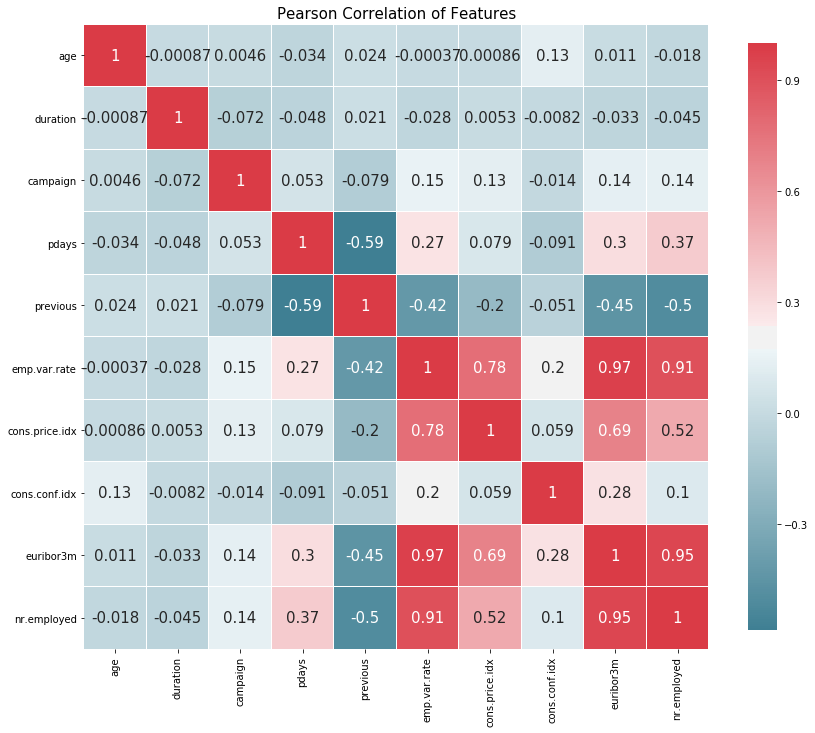

In [13]:
#calling function to plot heatmap 
correlation_heatmap(cdf)

# Univariate Plots

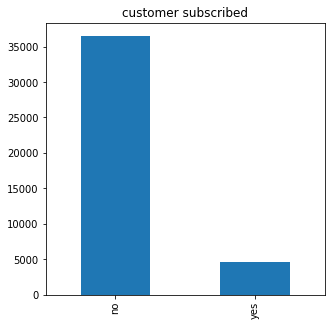

In [14]:
#the dataset has high imbalance in target variable which might required 
#to be handled by re-sampling techniques 
cdf['y'].value_counts().plot.bar(figsize=(5,5),title='customer subscribed');

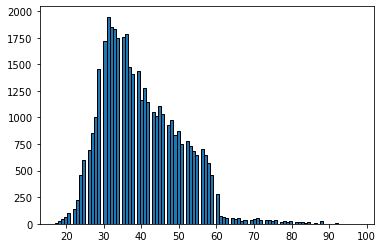

In [15]:
#lets see the age distribution of customers who were part of the campaign
plt.hist(cdf['age'], bins = 100, edgecolor = 'k');

# Bivariate Plots

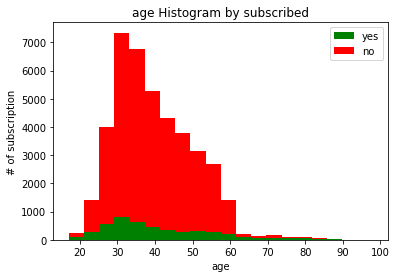

In [16]:
#lets see whether customer age mattered for subscription or not
plt.hist(x = [cdf[cdf['y']=='yes']['age'], cdf[cdf['y']=='no']['age']],
         bins=20, color = ['g','r'],stacked=True,label = ['yes','no'])
plt.title('age Histogram by subscribed')
plt.xlabel('age')
plt.ylabel('# of subscription')
plt.legend()

We can see that although target is highly imbalanced, customers who are below 25 and above 60 have higher subscription rate.

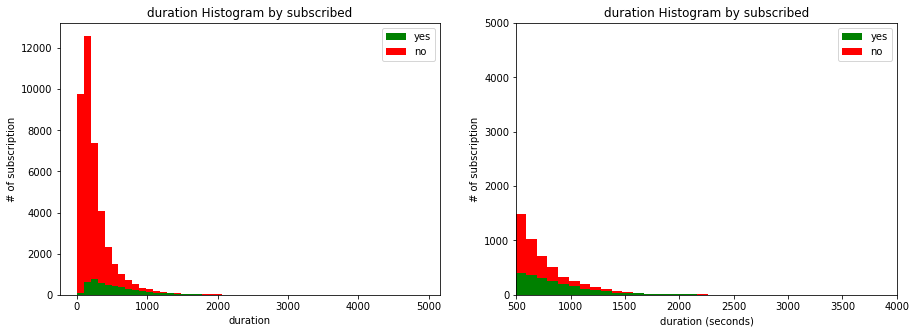

In [17]:
#lets see if call duration affects subscription rate
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(x = [cdf[cdf['y']=='yes']['duration'], cdf[cdf['y']=='no']['duration']],bins=50, color = ['g','r'],stacked=True,label = ['yes','no'])
plt.title('duration Histogram by subscribed')
plt.xlabel('duration')
plt.ylabel('# of subscription')
plt.legend()

plt.subplot(122)
plt.hist(x = [cdf[cdf['y']=='yes']['duration'], cdf[cdf['y']=='no']['duration']],bins=50, color = ['g','r'],stacked=True,label = ['yes','no'])
plt.title('duration Histogram by subscribed')
plt.xlabel('duration (seconds)')
plt.ylabel('# of subscription')
plt.ylim(0,5000)
plt.xlim(500,4000)
plt.legend()

In second plot we can clearly see that as call duration increases there are high chances of success, although note that we cannot use duration feature in modelling 
because at the time of prediction we dont know for how long customer will be on the call, we have to decide apriori.



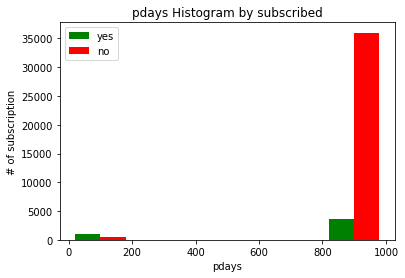

In [18]:
#pdays- number of days that passed by after the client was last contacted from a previous campaign 
#pdays=999 means the client was not contacted in previous campaign
plt.hist(x = [cdf[cdf['y']=='yes']['pdays'], cdf[cdf['y']=='no']['pdays']],bins=5, color = ['g','r'],stacked=False,label = ['yes','no'])
plt.title('pdays Histogram by subscribed')
plt.xlabel('pdays')
plt.ylabel('# of subscription')
plt.legend()

Even though our target data is imbalanced we can see that for lower pdays we have higher success rates

To plot target against catagorical variables we will need to encode it.

In [19]:
le = LabelEncoder()
cdf['y']=le.fit_transform(cdf['y'])

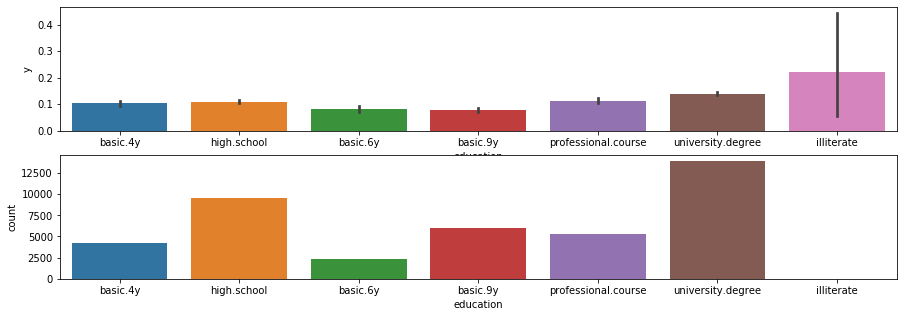

In [20]:
#Does education matters for subscription, lets see.
plt.figure(figsize=(15,5))
plt.subplot(211)
sns.barplot(x='education', y = 'y', data=cdf)
plt.subplot(212)
sns.countplot(x='education',data=cdf)

Even though we see illiterate have higher pecentage of 'yes' , as per countplot there are not many people in that category. all other categories have similar subscription rate.

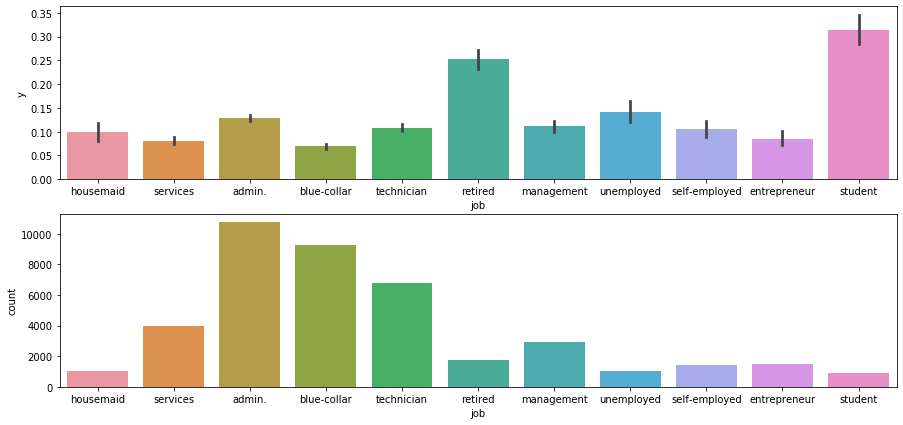

In [21]:
#Does job matters for subscription?
plt.figure(figsize=(15,7))
plt.subplot(211)
sns.barplot(x='job', y = 'y', data=cdf)
plt.subplot(212)
sns.countplot(x='job',data=cdf)

From the above plot we can see subscription rate varies for different job catagories

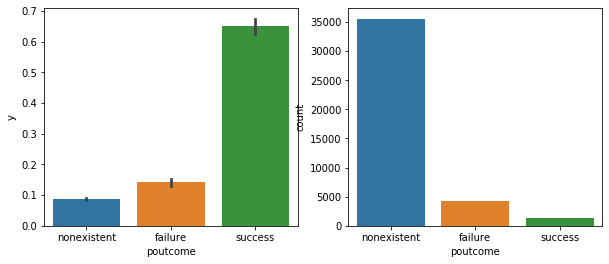

In [22]:
#poutcome- outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.barplot(x='poutcome', y = 'y', data=cdf)
plt.subplot(122)
sns.countplot('poutcome', data=cdf)

Above plot shows if previous campaign was success for a particular client then there is high chance of client subscribing for term deposit. We can see there are many people that were not part of earlier campaign.

how does month affects subsciption rate?
plt.figure(figsize=(10,6))
plt.subplot(211)
sns.barplot(x='month', y = 'y', data=cdf)
plt.subplot(212)
sns.countplot(x='month', data=cdf)

We can see highest activity month for bank is May. Month of October, December, March and September have higher subscription rates

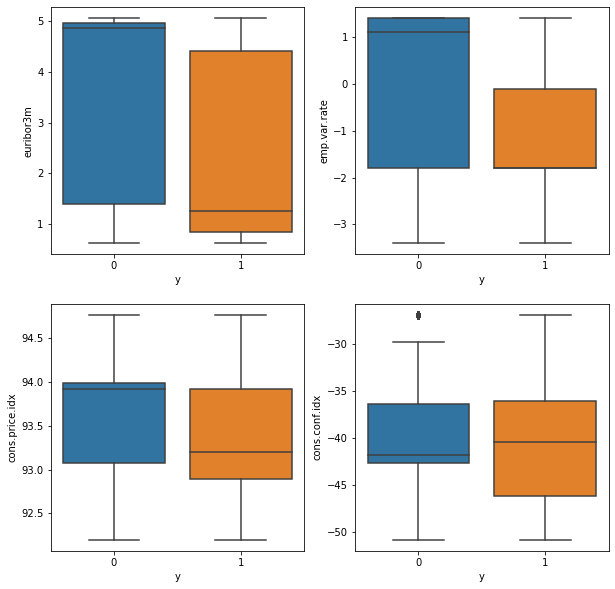

In [23]:
#lets see how social and economic context attribute matters
plt.figure(figsize=(10,10))
plt.subplot(221)
sns.boxplot(y='euribor3m',x='y',data=cdf)
plt.subplot(222)
sns.boxplot(y='emp.var.rate',x='y',data=cdf)
plt.subplot(223)
sns.boxplot(y='cons.price.idx',x='y',data=cdf)
plt.subplot(224)   
sns.boxplot(y='cons.conf.idx',x='y',data=cdf)

Above boxplots shows that euribor3m and emp.var.rate does affect subscription rate. cons.price.idx and cons.conf.idx have almost same median for positive and negative class.

# Multi-variate plots

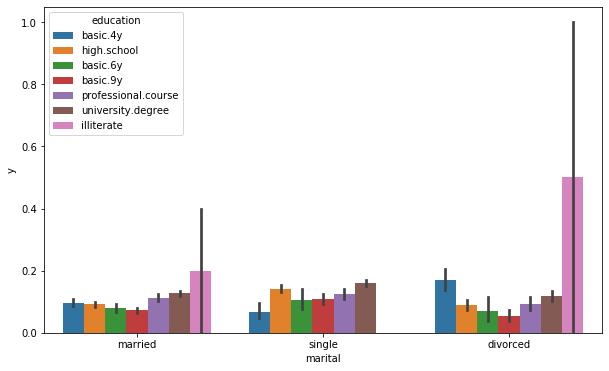

In [24]:
#how does marital status and education together affects subscription rate
plt.figure(figsize=(10,6))
sns.barplot(x='marital', y = 'y', hue='education',data=cdf)

We can see that married and divorced people with different education have different subscription rate, unlike single which has almost similar subscription rates for different education background.

Since some algorithms cannot work with categorical variables as is, it is best practise to encode categorical variables.

In [25]:
edf = cdf.copy()

#create a list of categorical features
cat_var = edf.select_dtypes(include='object').columns.values.tolist()

le = LabelEncoder()
for i in range(0,len(cat_var)):
    edf[cat_var[i]]=le.fit_transform(cdf[cat_var[i]])

#We will drop duration feature at it cannot be used while building the model
edf.drop('duration',axis=1,inplace=True);

In [26]:
#create a list of machine learning classification algorithms to apply  
MLA = [LogisticRegression(),RandomForestClassifier(),AdaBoostClassifier(),
       GradientBoostingClassifier(),XGBClassifier()]

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'F1-score', 'AUC score']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#get the target feature
y=edf.iloc[:,-1]

#we will do stratified split with 70% train and 30%test data
X_train,X_test,y_train,y_test = train_test_split(edf.iloc[:,:-1],y,
                                                 test_size=0.3,random_state=42,stratify=y)

row_index = 0
start = time.perf_counter()
for alg in MLA:
    #set algorithm name
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
   #fit the model and do the predictions of test data
    alg.fit(X_train,y_train)
    y_pred = alg.predict(X_test)
    #get the F1-score and AUC score and insert into the table
    MLA_compare.loc[row_index, 'F1-score'] = f1_score(y_test,y_pred)
    MLA_compare.loc[row_index, 'AUC score'] = roc_auc_score(y_test,y_pred)  
    row_index+=1
end = time.perf_counter()
print('total run time in seconds %0.2f'%(end - start));

total run time in seconds 19.58


Confusion matrix, without normalization
[[10649   316]
 [  985   407]]


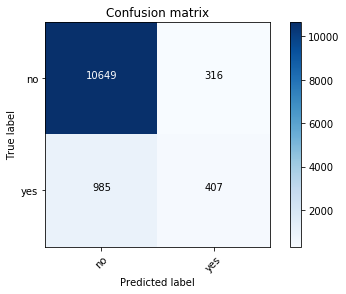

In [27]:
#below code plots pretty looking confusion matrix, code was taken from one of the kaggle karnel
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#lets apply default random forest model and see if the above function works fine
alg = RandomForestClassifier()
alg.fit(X_train,y_train)
y_pred = alg.predict(X_test)

#function call to plot confusion matrix for default random forest prediction
plot_confusion_matrix(confusion_matrix(y_test,y_pred),classes=['no','yes'])    

In [28]:
MLA_compare

,MLA Name,F1-score,AUC score
0,LogisticRegression,0.292458,0.587086
1,RandomForestClassifier,0.384688,0.631737
2,AdaBoostClassifier,0.326531,0.600622
3,GradientBoostingClassifier,0.355602,0.613611
4,XGBClassifier,0.338965,0.605691


As we can see in above table F1 score is not really good, we know that our dataset is imbalanced hence predictions are favoring majority class. Lets apply resampling techniques and evaluate the results. Remember we have to resample only the training set and not the test set.

In [29]:
#lets do downsampling using cluster centroid technique
cc = ClusterCentroids(random_state=0)
X_sample,y_sample = cc.fit_sample(X_train,y_train)
#rus = RandomUnderSampler(random_state=0)
#X_sample,y_sample = rus.fit_sample(X_train,y_train)

In [30]:
#ros = RandomOverSampler(random_state=0)
#X_sample,y_sample = ros.fit_sample(X_train,y_train)

#apply default random forest and see metrics
rf = RandomForestClassifier()
rf.fit(X_sample,y_sample)
y_pred = rf.predict(X_test)
print(('roc score',roc_auc_score(y_pred,y_test)))
print(('f1 score',f1_score(y_pred,y_test)))

('roc score', 0.5229866720536026)
('f1 score', 0.20424007166318306)


In [31]:
#lets do oversampling using SMOTE 
smote = SMOTE(random_state=0)
X_sample1, y_sample1 = smote.fit_sample(X_train,y_train)

rf = RandomForestClassifier()
rf.fit(X_sample1,y_sample1)
y_pred = rf.predict(X_test)
print(('roc score',roc_auc_score(y_pred,y_test)))
print(('f1 score',f1_score(y_pred,y_test)))

('roc score', 0.7250827073368469)
('f1 score', 0.4182608695652174)


As you can see with oversampling evaluation metric were better compared to undersampling, so lets stick with oversampling. We should check to see if our default random forest works well across the folds.

In [32]:
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
scores = cross_val_score(rf, X_sample1, y_sample1, cv=kf, scoring='f1_macro')
scores

array([0.93988655, 0.94515846, 0.94008357, 0.94018181, 0.94164168])

Since our y_sample1 is balanced we see good F1 score across the folds, the actual score on test data which will have imbalance would be much lower than this.

In [33]:
print('Type of X_sample is ',type(X_sample1))
print('Type of X_test is ',type(X_test))

Type of X_sample is  <class 'numpy.ndarray'>
Type of X_test is  <class 'pandas.core.frame.DataFrame'>


As you can see data types of sampled data and test data is different which creates issues with XGB classifier, so we will convert test data as ndarray.

In [34]:
y=y_sample1.copy()
X_test = np.array(X_test)

In [35]:
MLA = [LogisticRegression(),RandomForestClassifier(),AdaBoostClassifier(),
       GradientBoostingClassifier(),XGBClassifier()]
#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'F1-score', 'AUC score']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#X_train,X_test,y_train,y_test = train_test_split(X_sample,y,test_size=0.3,random_state=42,stratify=y)
row_index = 0
start = time.perf_counter()
for alg in MLA:
    #set name of algorithms
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
   #fit the models and do predictions 
    alg.fit(X_sample1,y_sample1)
    y_pred = alg.predict(X_test)
    #insert the scores in table
    MLA_compare.loc[row_index, 'F1-score'] = f1_score(y_test,y_pred)
    MLA_compare.loc[row_index, 'AUC score'] = roc_auc_score(y_test,y_pred)  
    row_index+=1
end = time.perf_counter()
print('total run time in seconds %0.2f'%(end - start));

total run time in seconds 53.26


In [36]:
MLA_compare

,MLA Name,F1-score,AUC score
0,LogisticRegression,0.394037,0.733008
1,RandomForestClassifier,0.422743,0.655548
2,AdaBoostClassifier,0.468547,0.699653
3,GradientBoostingClassifier,0.440311,0.664089
4,XGBClassifier,0.444252,0.665623


Now its time to do hyperparameter tuning and see if our results get improve. I did gridsearch for all the above classifiers, since I dont have much computing resource on my local machine, I have shown individual models fitted with best parameters that I found from gridsearch.

In [37]:
#'n_estimators': [10, 50, 100, 300], #'learning_rate':[ 0.1, 0.2, 0.3] #'max_depth':[6,8,10]
param_grid={'max_features':['sqrt','log2',12]}
rf = RandomForestClassifier(n_estimators=100,max_depth=10)
grid_ = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1',cv=kf)
grid_.fit(X_sample1,y_sample1)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              o

In [38]:
grid_.best_score_

0.8952285932050794

In [39]:
grid_.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=12,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [40]:
clf3 = LogisticRegression(C=0.1)
clf3.fit(X_sample1,y_sample1)
y_pred3 = clf3.predict(X_test)
print(('roc score'),roc_auc_score(y_test,y_pred3))
print(('f1 score'),f1_score(y_test,y_pred3))
print(('accuracy score'),accuracy_score(y_test,y_pred3))

roc score 0.7311620438070977
f1 score 0.38739972608100176
accuracy score 0.7466213482236789


In [41]:
clf2 = XGBClassifier(max_depth=10,n_estimators=300)
clf2.fit(X_sample1,y_sample1)
y_pred2 = clf2.predict(X_test)
print(('roc score'),roc_auc_score(y_test,y_pred2))
print(('f1 score'),f1_score(y_test,y_pred2))
print(('accuracy score'),accuracy_score(y_test,y_pred2))

roc score 0.6441780862304827
f1 score 0.41118881118881123
accuracy score 0.8977907259043457


In [42]:
clf1 = RandomForestClassifier(n_estimators=100,max_depth=8)
clf1.fit(X_sample1,y_sample1)
y_pred1 = clf1.predict(X_test)
print(('roc score'),roc_auc_score(y_test,y_pred1))
print(('f1 score'),f1_score(y_test,y_pred1))
print(('accuracy score'),accuracy_score(y_test,y_pred1))

roc score 0.7444582684717832
f1 score 0.5123595505617977
accuracy score 0.8770737233956462


In [43]:
clf = AdaBoostClassifier(learning_rate=0.3,n_estimators=300)
clf.fit(X_sample1,y_sample1)
y_pred = clf.predict(X_test)
print(('roc score'),roc_auc_score(y_test,y_pred))
print(('f1 score'),f1_score(y_test,y_pred))
print(('accuracy score'),accuracy_score(y_test,y_pred))

roc score 0.6745752551220969
f1 score 0.44971381847914965
accuracy score 0.8910738852472283


 ROC AUC CURVE

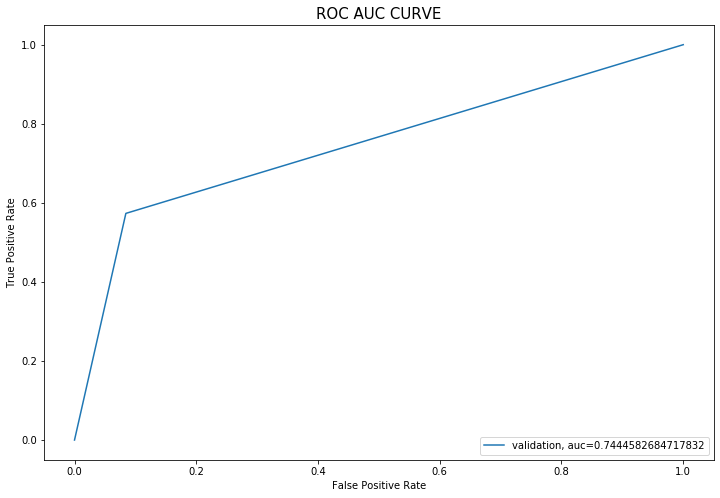

In [44]:
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred1)
auc = metrics.roc_auc_score(y_test,y_pred1)
plt.figure(figsize=(12,8))
plt.plot(fpr,tpr,label="validation, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.title('ROC AUC CURVE',fontsize=15)
plt.show()

Confusion matrix, without normalization
[[10040   925]
 [  594   798]]


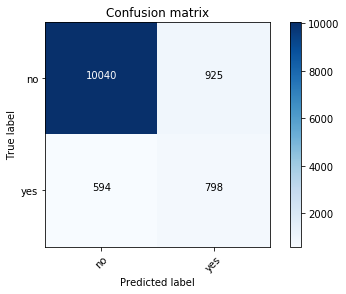

In [45]:
plot_confusion_matrix(confusion_matrix(y_test,y_pred1),classes=['no','yes'],normalize=False,title='Confusion matrix',cmap=plt.cm.Blues)

In [46]:
from sklearn import ensemble
vote_est = [('rfc', RandomForestClassifier(n_estimators=100,max_depth=8)),
            ('lr', LogisticRegression(C=0.1)),
            ('xgb', XGBClassifier(max_depth=10,n_estimators=300)),
            ('ada', AdaBoostClassifier(learning_rate=0.3,n_estimators=300))]
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_hard.fit(X_sample1,y_sample1)
y_pred = vote_hard.predict(X_test)
print(('roc score'),roc_auc_score(y_test,y_pred))
print(('f1 score'),f1_score(y_test,y_pred))
print(('accuracy score'),accuracy_score(y_test,y_pred))

roc score 0.7284689136280013
f1 score 0.5101327742837176
accuracy score 0.8865420409484502


We can see that random forest classifier gave us better results after hyper parameter tuning.